In [18]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import warnings
warnings.filterwarnings("ignore")

import gc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch.utils.metrics
from torchmetrics.classification import JaccardIndex
from albumentations.pytorch.transforms import ToTensorV2

In [19]:
DATA_DIR = './'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x


In [20]:
class Dataset(BaseDataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = []
        self.mask_paths  = []

        for image_id in os.listdir(images_dir):
            self.image_paths.append (os.path.join(images_dir, image_id)) 
            self.mask_paths.append(os.path.join(masks_dir, image_id[:-1]))

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        
        image = cv2.imread(self.image_paths[i], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], cv2.COLOR_BGR2GRAY)
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask'] 
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
        else:
            _transform = album.Compose([ToTensorV2()])
            transformed = _transform(image = image, mask = mask)
            image = transformed['image']
            mask  = transformed['mask']

        new_mask = np.zeros((1, mask.shape[0], mask.shape[1]))
        new_mask[0] = np.where(mask == 0, 0, 1)
        
        return image, new_mask
        
    def __len__(self):
        return len(self.image_paths)

In [21]:
def image_shower(images, labels, phase = None, predict = None, n=4):

    for _ in range(n):

        if phase == 'test':
            fig, axes = plt.subplots(1, 3)
        else:
            fig, axes = plt.subplots(1, 2)
        fig.set_figwidth(12) 
        fig.set_figheight(6)

        if len(images.shape) == 4:
            axes[0].imshow(images[_].numpy().transpose((1, 2, 0)).squeeze())
            axes[0].set_title('IMAGE')
            axes[1].imshow(labels[_][0].numpy().squeeze())
            axes[1].set_title('MASK')
            if phase == 'test':
                axes[2].imshow(predict[_].numpy().transpose((1, 2, 0)).squeeze())
                axes[2].set_title('PREDICT_MASK')
        else:
            axes[0].imshow(images.numpy().transpose((1, 2, 0)).squeeze())
            axes[0].set_title('IMAGE')
            axes[1].imshow(labels.squeeze())
            axes[1].set_title('MASK')
    plt.show()


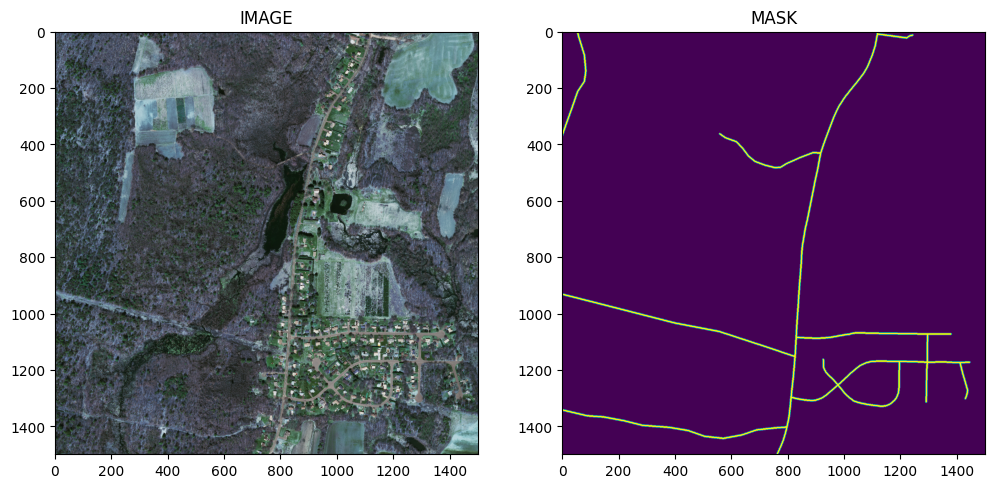

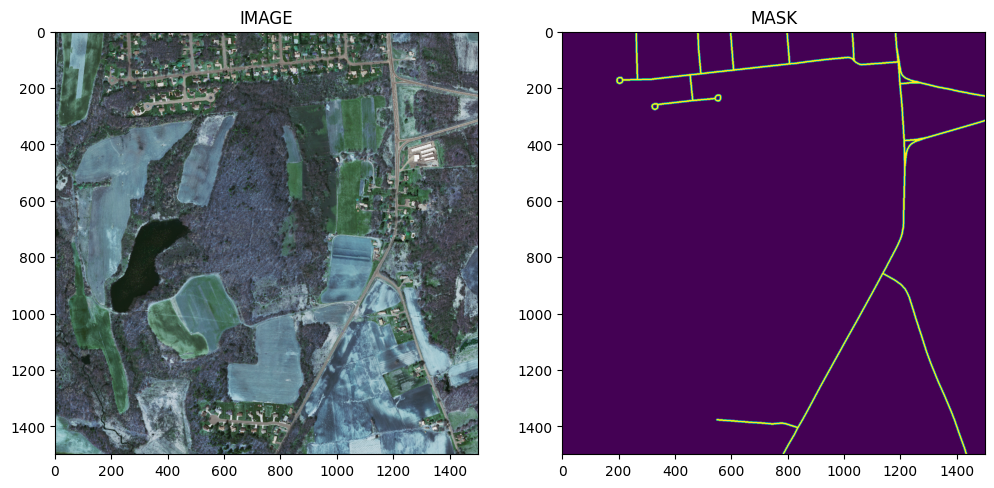

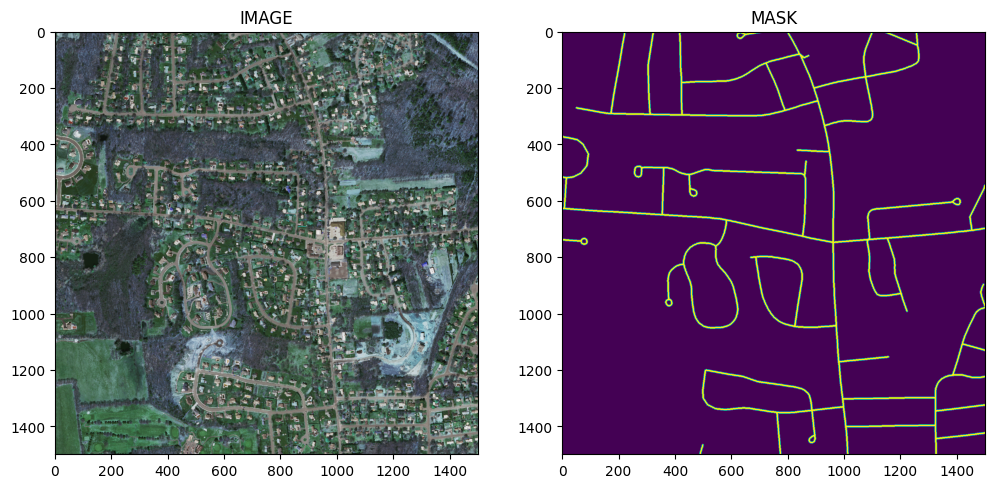

In [22]:
dataset = Dataset(x_train_dir, y_train_dir)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx] 


for i in range(3):
    images, labels = dataset[i]
    image_shower(images, labels, n=1)


In [23]:
def get_preprocessing(preprocessing_fn):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return album.Compose(_transform)
get_augmentation = {
    'train':
        album.Compose([
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),]),
    'valid':
        album.Compose([
        album.RandomCrop(height=256, width=256, always_apply=True),
        # album.Resize(256,256),
        # album.PadIfNeeded(min_height=1408, min_width=1408, always_apply=True, border_mode=0),
        ]),
    'test':
        album.Compose([
        # album.Resize(224,224),
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        ]),
}

In [24]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
model.to(DEVICE)
print(DEVICE)

cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


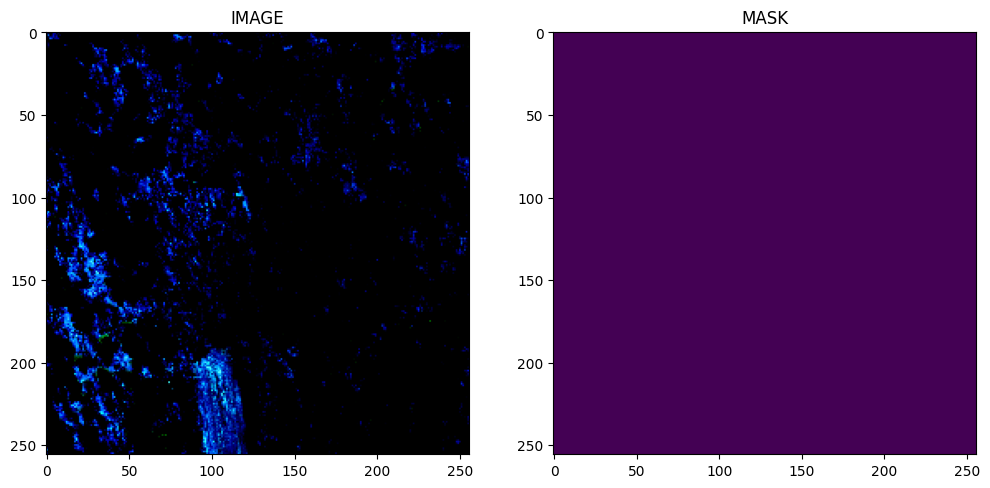

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


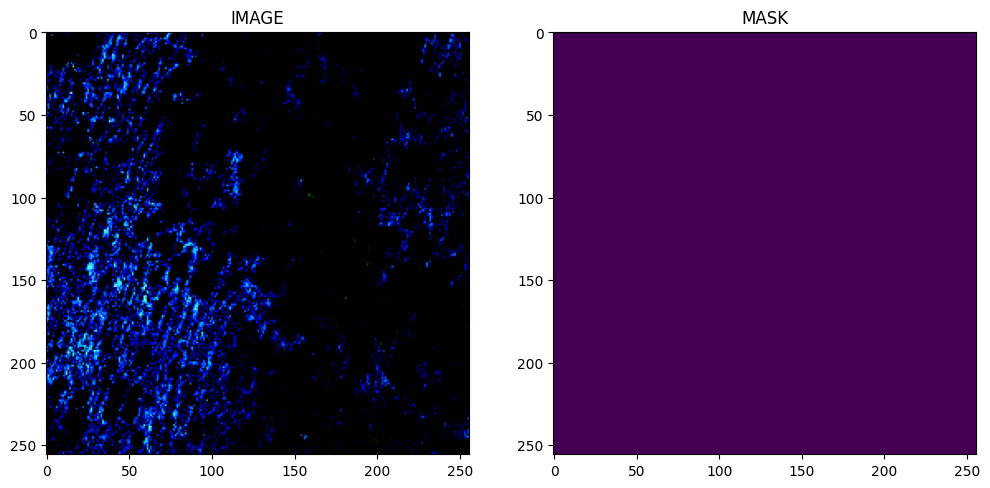

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


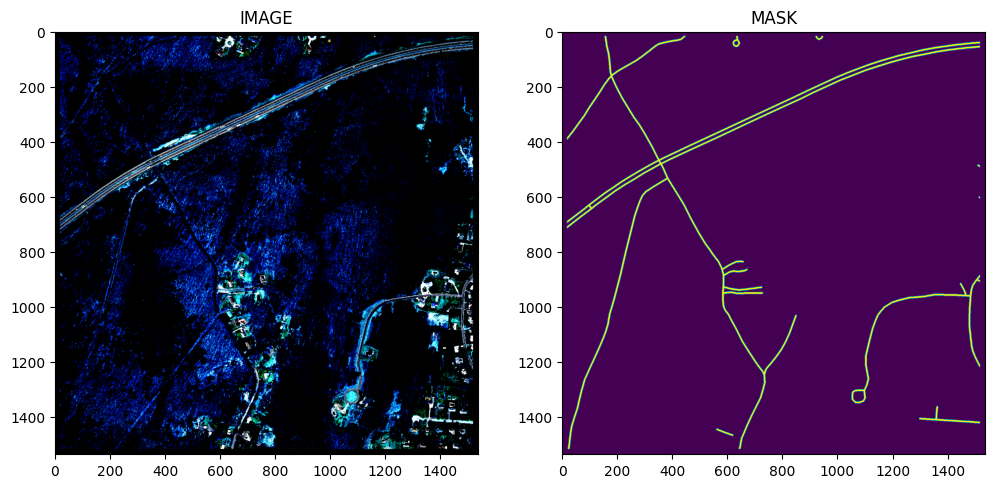

In [25]:
data_image = {
    'train':
        Dataset(x_train_dir, y_train_dir, augmentation=get_augmentation['train'],preprocessing=get_preprocessing(preprocessing_fn)),
    'validation':
        Dataset(x_test_dir, y_test_dir, augmentation=get_augmentation['valid'], preprocessing=get_preprocessing(preprocessing_fn)),
    'test':
        Dataset(x_test_dir, y_test_dir,augmentation=get_augmentation['test'], preprocessing=get_preprocessing(preprocessing_fn)),

}

loaders_image = {
    'train':
        DataLoader(data_image['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'validation':
        DataLoader(data_image['validation'], batch_size=1, shuffle=True, num_workers=0),
    'test':
        DataLoader(data_image['test'], batch_size=1, shuffle=True, num_workers=0),
}

for phase in data_image:
    images, labels = data_image[phase][0]
    image_shower(images, labels, n=1)



In [26]:
criterion = smp.losses.SoftBCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5,)

In [27]:
train_losses = []
valid_losses = []
train_iou = []
valid_iou = []
lr = [0.0001]
NUM_EPOCHS = 60
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            out = []

            for inputs, labels in loaders_image[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs.float())
                loss = criterion(outputs, labels.float())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                tp, fp, fn, tn = smp.metrics.get_stats((outputs.sigmoid()>0.5).long(), labels.long(), mode='binary')
                out.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
                running_loss += loss.item() * inputs.size(0)

            lr_scheduler.step()
            lr.append(optimizer.param_groups[0]["lr"])
            epoch_loss = running_loss / len(data_image[phase])
            tp = torch.cat([x["tp"] for x in out])
            fp = torch.cat([x["fp"] for x in out])
            fn = torch.cat([x["fn"] for x in out])
            tn = torch.cat([x["tn"] for x in out])
            epoch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_iou.append(epoch_iou)

            else:
                valid_losses.append(epoch_loss)
                valid_iou.append(epoch_iou)

                if best_iou < epoch_iou: 
                    best_iou = epoch_iou
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model, './best_model.pth')
            print('{} loss: {:.4f}, epoch_iou: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_iou*100))
        print()            
    return model.load_state_dict(best_model_wts)

train_model(model, criterion, optimizer)


Epoch 1/60
----------
train loss: 0.5370, epoch_iou: 5.7630
validation loss: 0.4484, epoch_iou: 5.1581

Epoch 2/60
----------
train loss: 0.3949, epoch_iou: 3.6680
validation loss: 0.3748, epoch_iou: 3.2113

Epoch 3/60
----------
train loss: 0.3295, epoch_iou: 8.7717
validation loss: 0.2852, epoch_iou: 15.6302

Epoch 4/60
----------
train loss: 0.2881, epoch_iou: 23.1360
validation loss: 0.2405, epoch_iou: 23.1014

Epoch 5/60
----------
train loss: 0.2560, epoch_iou: 28.4466
validation loss: 0.2241, epoch_iou: 31.5340

Epoch 6/60
----------
train loss: 0.2207, epoch_iou: 35.7127
validation loss: 0.1868, epoch_iou: 42.9226

Epoch 7/60
----------
train loss: 0.2001, epoch_iou: 40.7494
validation loss: 0.1714, epoch_iou: 51.6701

Epoch 8/60
----------
train loss: 0.1840, epoch_iou: 47.2477
validation loss: 0.1547, epoch_iou: 48.7227

Epoch 9/60
----------
train loss: 0.1715, epoch_iou: 47.9860
validation loss: 0.1524, epoch_iou: 48.0610

Epoch 10/60
----------
train loss: 0.1555, epoch_io

<All keys matched successfully>

Text(0, 0.5, 'Loss')

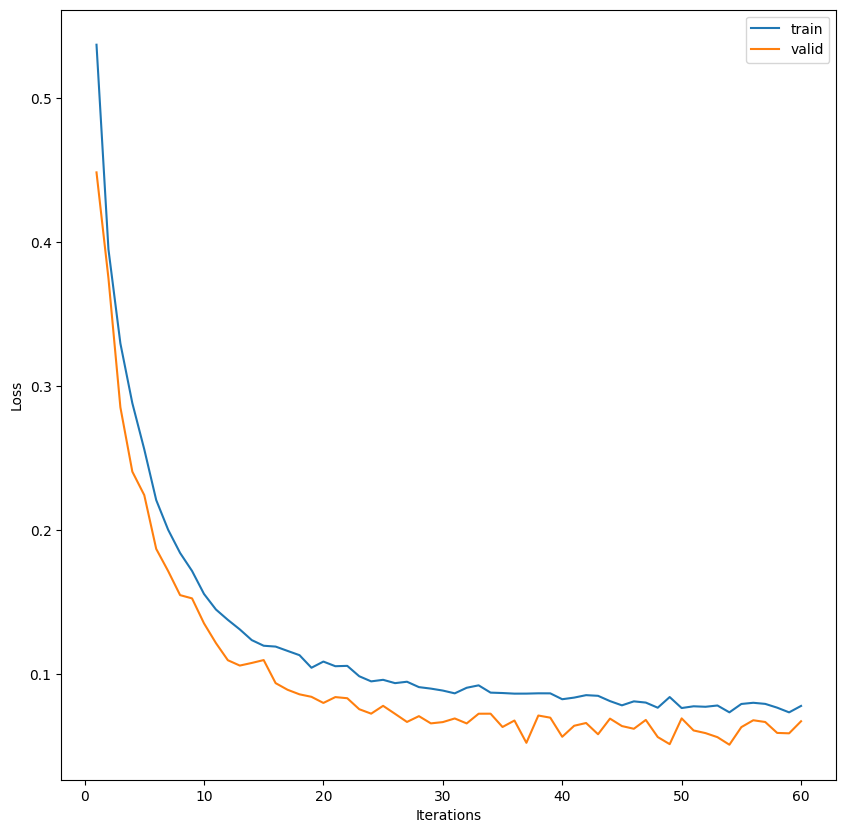

In [28]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train')
plt.plot(range(1, NUM_EPOCHS + 1), valid_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

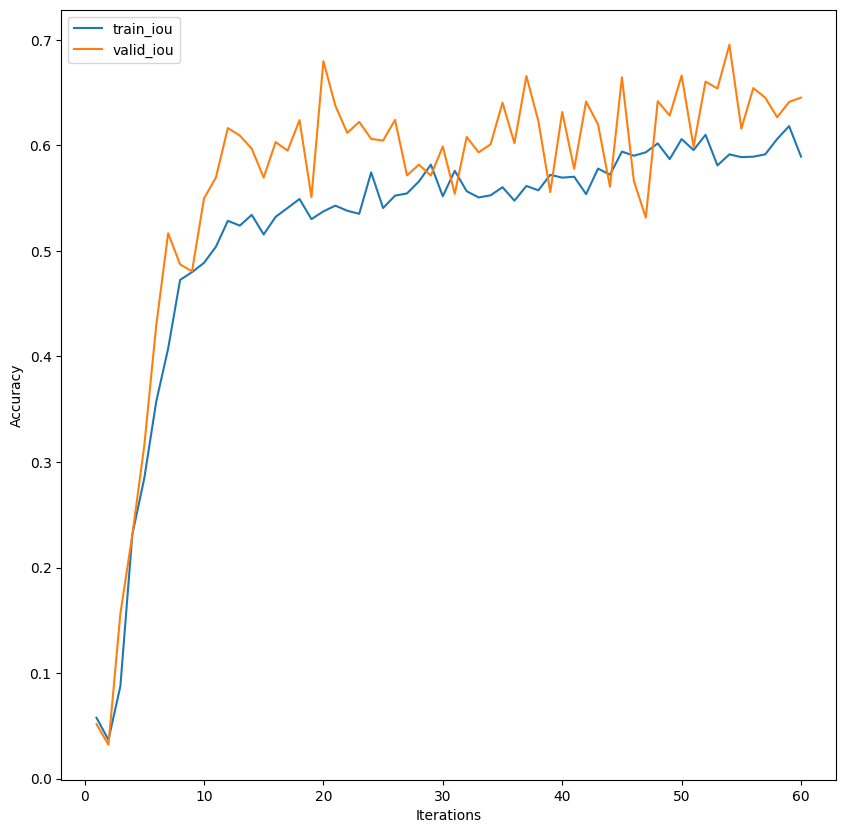

In [29]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, NUM_EPOCHS + 1), train_iou, label='train_iou')
plt.plot(range(1, NUM_EPOCHS + 1), valid_iou, label='valid_iou')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.show()

Text(0, 0.5, 'Lr')

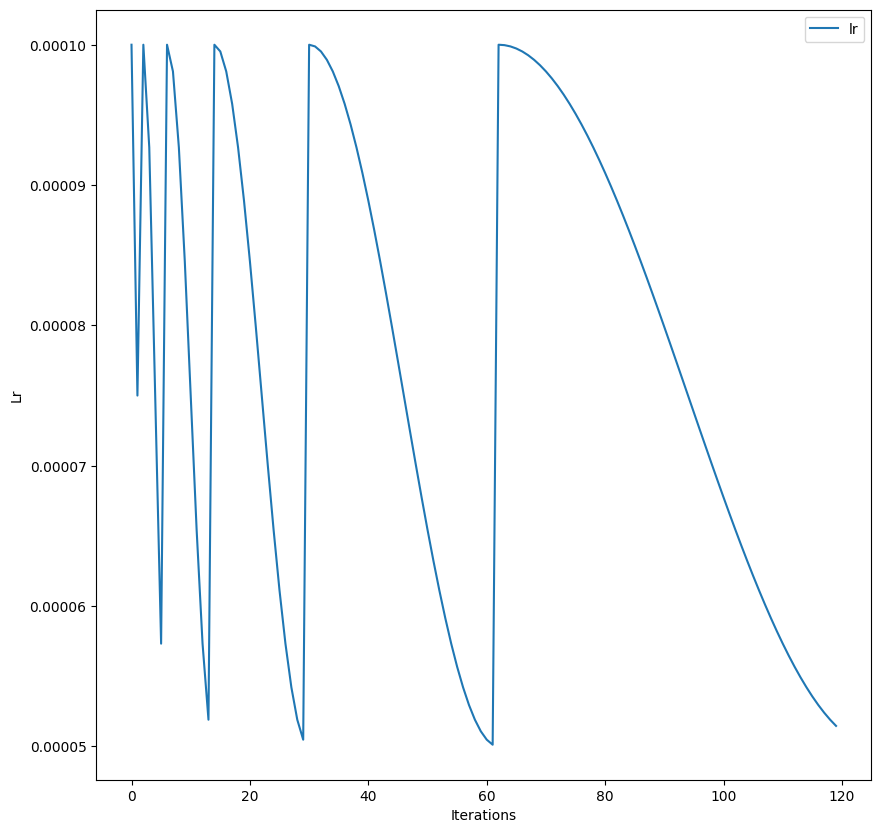

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.plot(lr[1:], label='lr')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Lr')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


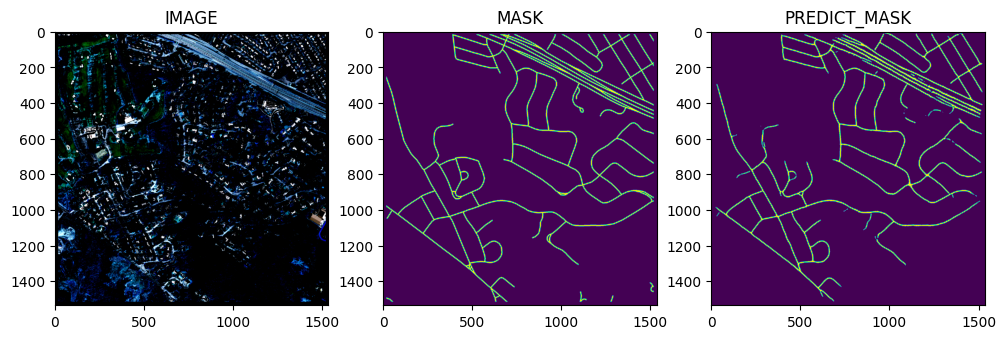

IOU of the network on the 49 test images: 60.6487 %


In [32]:
out = []
with torch.no_grad():
    total = 0
    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = (model(images).sigmoid()>0.5).long()
        total += labels.size(0)

        if not i:
            image_shower(images.cpu(), labels.cpu(), n=1, predict=outputs.cpu(), phase='test')

        tp, fp, fn, tn = smp.metrics.get_stats((outputs.sigmoid()>0.5).long(), labels.long(), mode='binary')
        out.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    tp = torch.cat([x["tp"] for x in out])
    fp = torch.cat([x["fp"] for x in out])
    fn = torch.cat([x["fn"] for x in out])
    tn = torch.cat([x["tn"] for x in out])
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
    print('IOU of the network on the {} test images: {:.4f} %'.format(total, 100 * iou))